# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import time
import catboost as cb
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")
df.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,USD,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M


In [4]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [5]:
valid_categories = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'],
    'employment_type': ['FT', 'PT', 'CT', 'FL'],
    'remote_ratio': [0, 50, 100],
    'company_size': ['S', 'M', 'L']
}

for col, valid_vals in valid_categories.items():
    invalid_vals = set(df[col]) - set(valid_vals)
    print(f"{col} invalid values:", invalid_vals if invalid_vals else "No issues")

experience_level invalid values: No issues
employment_type invalid values: No issues
remote_ratio invalid values: No issues
company_size invalid values: No issues


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [6]:
print(df.isnull().sum())
print(f"Число дубликатов: {df.duplicated().sum()}")
print(df.dtypes)


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
Число дубликатов: 1171
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


In [7]:
df[df.duplicated()].head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
115,2023,SE,FT,Data Scientist,150000,USD,150000,US,0,US,M
123,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
153,2023,MI,FT,Data Engineer,100000,USD,100000,US,100,US,M
154,2023,MI,FT,Data Engineer,70000,USD,70000,US,100,US,M
160,2023,SE,FT,Data Engineer,115000,USD,115000,US,0,US,M


In [8]:
duplicate_check = df.duplicated(subset=[col for col in df.columns if col != "salary_in_usd"], keep=False)
df[duplicate_check].sort_values(by=["job_title", "experience_level"]).head(20)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
117,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
119,2023,SE,FT,Analytics Engineer,179820,USD,179820,US,0,US,M
120,2023,SE,FT,Analytics Engineer,143860,USD,143860,US,0,US,M
123,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
401,2023,SE,FT,Analytics Engineer,179820,USD,179820,US,0,US,M
402,2023,SE,FT,Analytics Engineer,143860,USD,143860,US,0,US,M
545,2023,SE,FT,Analytics Engineer,179820,USD,179820,US,0,US,M
546,2023,SE,FT,Analytics Engineer,143860,USD,143860,US,0,US,M
2097,2022,SE,FT,Analytics Engineer,170000,USD,170000,US,100,US,M
2323,2022,SE,FT,Analytics Engineer,231250,USD,231250,US,100,US,M


In [9]:
df = df.groupby([col for col in df.columns if col != "salary_in_usd"], as_index=False).agg({"salary_in_usd": "mean"})

In [10]:
print(f"Число дубликатов: {df.duplicated().sum()}")

Число дубликатов: 0


## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

**Ваши выводы здесь**

In [11]:
df.drop(['salary', 'salary_currency'], axis=1, inplace=True)

salary, salary_currency лишние, так как уже есть целевая переменная salary_in_usd

Много категорий в job_title, employee_residence, company_location

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [12]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [13]:
num_features = ['work_year', 'remote_ratio']
cat_features = ['experience_level', 'employment_type', 'job_title',
                'employee_residence', 'company_location', 'company_size']

X_train_num = train[num_features]
X_test_num = test[num_features]

X_train_full = train[num_features + cat_features]
X_test_full = test[num_features + cat_features]

y_train = train['salary_in_usd']
y_test = test['salary_in_usd']

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [14]:
lr = LinearRegression().fit(X_train_num, y_train)
pred_lr = lr.predict(X_test_num)

mape = mean_absolute_percentage_error(y_test, pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, pred_lr))

print(f"MAPE: {mape:.3f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.732
RMSE: 65676.36


Как видно ошибка очень большая, модель слабая из-за малого количества числовых признаков.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
model_cb = cb.CatBoostRegressor(verbose=False).fit(X_train_num, y_train)
pred_cb = model_cb.predict(X_test_num)

mape_cb = mean_absolute_percentage_error(y_test, pred_cb)
rmse_cb = np.sqrt(mean_squared_error(y_test, pred_cb))

print(f"MAPE CatBoost: {mape_cb:.3f}")
print(f"RMSE CatBoost: {rmse_cb:.2f}")

MAPE CatBoost: 0.708
RMSE CatBoost: 64737.42


 CatBoost лучше линейной регрессии, но всё ещё слаб.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train_full[cat_features])

X_train_ohe = np.hstack([X_train_num, ohe.transform(X_train_full[cat_features])])
X_test_ohe = np.hstack([X_test_num, ohe.transform(X_test_full[cat_features])])

In [17]:
model_cb_ohe = cb.CatBoostRegressor(verbose=False).fit(X_train_ohe, y_train)
pred_cb_ohe = model_cb_ohe.predict(X_test_ohe)

lr_ohe = LinearRegression().fit(X_train_ohe, y_train)
pred_lr_ohe = lr_ohe.predict(X_test_ohe)

mape_cb_ohe = mean_absolute_percentage_error(y_test, pred_cb_ohe)
rmse_cb_ohe = np.sqrt(mean_squared_error(y_test, pred_cb_ohe))

mape_lr_ohe = mean_absolute_percentage_error(y_test, pred_lr_ohe)
rmse_lr_ohe = np.sqrt(mean_squared_error(y_test, pred_lr_ohe))

print(f"OHE CatBoost - MAPE: {mape_cb_ohe:.3f}, RMSE: {rmse_cb_ohe:.2f}")
print(f"OHE Linear Regression - MAPE: {mape_lr_ohe:.3f}, RMSE: {rmse_lr_ohe:.2f}")

OHE CatBoost - MAPE: 0.415, RMSE: 51603.38
OHE Linear Regression - MAPE: 0.451, RMSE: 51889.18


In [18]:
X_train_le = X_train_full[cat_features].copy()
X_test_le = X_test_full[cat_features].copy()

for col in cat_features:
    le = LabelEncoder().fit(X_train_le[col])
    X_train_le[col] = le.transform(X_train_le[col])
    X_test_le[col] = X_test_le[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

X_train_le_final = np.hstack([X_train_num, X_train_le])
X_test_le_final = np.hstack([X_test_num, X_test_le])

model_cb_le = cb.CatBoostRegressor(verbose=False).fit(X_train_le_final, y_train)
pred_cb_le = model_cb_le.predict(X_test_le_final)

lr_le = LinearRegression().fit(X_train_le_final, y_train)
pred_lr_le = lr_le.predict(X_test_le_final)

mape_cb_le = mean_absolute_percentage_error(y_test, pred_cb_le)
rmse_cb_le = np.sqrt(mean_squared_error(y_test, pred_cb_le))

mape_lr_le = mean_absolute_percentage_error(y_test, pred_lr_le)
rmse_lr_le = np.sqrt(mean_squared_error(y_test, pred_lr_le))

print(f"LE CatBoost - MAPE: {mape_cb_le:.3f}, RMSE: {rmse_cb_le:.2f}")
print(f"LE Linear Regression - MAPE: {mape_lr_le:.3f}, RMSE: {rmse_lr_le:.2f}")

LE CatBoost - MAPE: 0.434, RMSE: 51991.11
LE Linear Regression - MAPE: 0.556, RMSE: 58076.50


In [ ]:
te = TargetEncoder()
te.fit(X_train_full[cat_features], y_train)

X_train_te = np.hstack([X_train_num, te.transform(X_train_full[cat_features])])
X_test_te = np.hstack([X_test_num, te.transform(X_test_full[cat_features])])

model_cb_te = cb.CatBoostRegressor(verbose=False).fit(X_train_te, y_train)
pred_cb_te = model_cb_te.predict(X_test_te)

lr_te = LinearRegression().fit(X_train_te, y_train)
pred_lr_te = lr_te.predict(X_test_te)

mape_cb_te = mean_absolute_percentage_error(y_test, pred_cb_te)
rmse_cb_te = np.sqrt(mean_squared_error(y_test, pred_cb_te))

mape_lr_te = mean_absolute_percentage_error(y_test, pred_lr_te)
rmse_lr_te = np.sqrt(mean_squared_error(y_test, pred_lr_te))

print(f"MeanTE CatBoost - MAPE: {mape_cb_te:.3f}, RMSE: {rmse_cb_te:.2f}")
print(f"MeanTE Linear Regression - MAPE: {mape_lr_te:.3f}, RMSE: {rmse_lr_te:.2f}")

MeanTE CatBoost - MAPE: 0.425, RMSE: 51296.92
MeanTE Linear Regression - MAPE: 0.472, RMSE: 52993.56


In [20]:
print(f"OHE CatBoost - MAPE: {mape_cb_ohe:.3f}, RMSE: {rmse_cb_ohe:.2f}")
print(f"OHE Linear Regression - MAPE: {mape_lr_ohe:.3f}, RMSE: {rmse_lr_ohe:.2f}")
print(f"LE CatBoost - MAPE: {mape_cb_le:.3f}, RMSE: {rmse_cb_le:.2f}")
print(f"LE Linear Regression - MAPE: {mape_lr_le:.3f}, RMSE: {rmse_lr_le:.2f}")
print(f"MeanTE CatBoost - MAPE: {mape_cb_te:.3f}, RMSE: {rmse_cb_te:.2f}")
print(f"MeanTE Linear Regression - MAPE: {mape_lr_te:.3f}, RMSE: {rmse_lr_te:.2f}")

OHE CatBoost - MAPE: 0.415, RMSE: 51603.38
OHE Linear Regression - MAPE: 0.451, RMSE: 51889.18
LE CatBoost - MAPE: 0.434, RMSE: 51991.11
LE Linear Regression - MAPE: 0.556, RMSE: 58076.50
MeanTE CatBoost - MAPE: 0.425, RMSE: 51296.92
MeanTE Linear Regression - MAPE: 0.472, RMSE: 52993.56


CatBoost с Mean Target Encoding — даёт наилучшее значение RMSE (51296.92), хотя немного уступает OHE по MAPE.
CatBoost с OHE также демонстрирует отличные результаты, особенно по метрике MAPE (0.415). Разница с MeanTE незначительна.
Label Encoding показал худшие результаты, особенно в сочетании с линейной регрессией
Линейная регрессия стабильно проигрывает CatBoost на всех типах кодирования

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [21]:
errors = np.abs(y_test - pred_cb_te)
top20_errors = test.copy()
top20_errors['prediction'] = pred_cb_te
top20_errors['error'] = errors
top20_errors = top20_errors.sort_values('error', ascending=False).head(20)

display(top20_errors)

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_in_usd,prediction,error
56,2020,MI,FT,Research Scientist,US,0,US,M,450000.0,164854.086868,285145.913132
67,2020,SE,FT,Data Scientist,US,100,US,L,412000.0,153904.898319,258095.101681
2013,2023,SE,FT,Data Analyst,US,0,US,M,385000.0,132808.330463,252191.669537
742,2022,SE,FT,AI Developer,CA,0,CA,S,275000.0,105090.621615,169909.378385
73,2020,SE,FT,Machine Learning Scientist,JP,0,JP,S,260000.0,98432.551159,161567.448841
2525,2023,SE,FT,Machine Learning Engineer,US,0,US,L,342300.0,195531.434636,146768.565364
2524,2023,SE,FT,Machine Learning Engineer,US,0,US,M,323300.0,182441.078091,140858.921909
57,2020,SE,FL,Computer Vision Engineer,RU,100,US,S,60000.0,194969.916886,134969.916886
2227,2023,SE,FT,Data Engineer,US,0,US,M,291500.0,166271.415335,125228.584665
457,2022,MI,FT,AI Scientist,IN,100,US,L,200000.0,76907.966483,123092.033517


**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
df['abroad'] = (df['employee_residence'] != df['company_location']).astype(int)
df['is_usa_company'] = (df['company_location'] == 'US').astype(int)

train, test = train_test_split(df, test_size=0.2, random_state=42)
num_features_new = ['work_year', 'remote_ratio', 'abroad', 'is_usa_company']
cat_features_new = ['experience_level', 'employment_type', 'job_title',
                    'employee_residence', 'company_location', 'company_size']

X_train_num_new = train[num_features_new]
X_test_num_new = test[num_features_new]

y_train_new = train['salary_in_usd']
y_test_new = test['salary_in_usd']

from category_encoders import TargetEncoder
te_new = TargetEncoder()
te_new.fit(train[cat_features_new], y_train_new)

X_train_te_new = np.hstack([X_train_num_new, te_new.transform(train[cat_features_new])])
X_test_te_new = np.hstack([X_test_num_new, te_new.transform(test[cat_features_new])])

model_cb_new = cb.CatBoostRegressor(verbose=False, random_state=42).fit(X_train_te_new, y_train_new)
pred_cb_new = model_cb_new.predict(X_test_te_new)

mape_cb_new = mean_absolute_percentage_error(y_test_new, pred_cb_new)
rmse_cb_new = np.sqrt(mean_squared_error(y_test_new, pred_cb_new))

print(f"CatBoost с новыми признаками - MAPE: {mape_cb_new:.3f}, RMSE: {rmse_cb_new:.2f}")


CatBoost с новыми признаками - MAPE: 0.423, RMSE: 51092.81


Выделение является ли компания иностранной или является ли она амеркиканской не дало прирост, также я локально попробовал выделить компнаии по регионам, но это не дало прироста качества

**Ваш ответ здесь**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
params_cb = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 300, 500]
}

grid_cb = GridSearchCV(
    cb.CatBoostRegressor(verbose=False, random_state=42),
    params_cb,
    cv=3,
    scoring='neg_root_mean_squared_error'
)

%time grid_cb.fit(X_train_te, y_train)

print("Лучшие гиперпараметры CatBoost:", grid_cb.best_params_)

best_cb_model = grid_cb.best_estimator_

%time preds_best_cb = best_cb_model.predict(X_test_te)

mape_best_cb = mean_absolute_percentage_error(y_test, preds_best_cb)
rmse_best_cb = np.sqrt(mean_squared_error(y_test, preds_best_cb))

print(f'Итоговая модель CatBoost - MAPE: {mape_best_cb:.3f}, RMSE: {rmse_best_cb:.2f}')

CPU times: user 46.5 s, sys: 6.19 s, total: 52.7 s
Wall time: 37.5 s
Лучшие гиперпараметры CatBoost: {'depth': 4, 'iterations': 300, 'learning_rate': 0.05}
CPU times: user 1.28 ms, sys: 0 ns, total: 1.28 ms
Wall time: 1.11 ms
Итоговая модель CatBoost - MAPE: 0.434, RMSE: 51042.84


## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
params_xgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500]
}

grid_xgb = GridSearchCV(
    xgb.XGBRegressor(random_state=42, verbose=-1),
    params_xgb,
    cv=3,
    scoring='neg_root_mean_squared_error'
)

%time grid_xgb.fit(X_train_te, y_train)

print("Лучшие гиперпараметры XGBoost:", grid_xgb.best_params_)

best_xgb_model = grid_xgb.best_estimator_

%time preds_best_xgb = best_xgb_model.predict(X_test_te)

mape_xgb = mean_absolute_percentage_error(y_test, preds_best_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_best_xgb))

print(f'Итоговый XGBoost - MAPE: {mape_xgb:.3f}, RMSE: {rmse_xgb:.2f}')

CPU times: user 47.4 s, sys: 738 ms, total: 48.2 s
Wall time: 29.4 s
Лучшие гиперпараметры XGBoost: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
CPU times: user 9.63 ms, sys: 42 µs, total: 9.67 ms
Wall time: 5.17 ms
Итоговый XGBoost - MAPE: 0.427, RMSE: 51026.46


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
params_lgb = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500]
}

grid_lgb = GridSearchCV(
    lgb.LGBMRegressor(random_state=42, verbose=-1),
    params_lgb,
    cv=3,
    scoring='neg_root_mean_squared_error'
)

grid_lgb.fit(X_train_te, y_train)

%time grid_lgb.fit(X_train_te, y_train)

print("Лучшие гиперпараметры LGBM:", grid_lgb.best_params_)

best_lgb_model = grid_lgb.best_estimator_

%time preds_best_lgb = best_lgb_model.predict(X_test_te)

mape_lgb = mean_absolute_percentage_error(y_test, preds_best_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_best_lgb))

print(f'Итоговый LightGBM - MAPE: {mape_lgb:.3f}, RMSE: {rmse_lgb:.2f}')


CPU times: user 16.2 s, sys: 835 ms, total: 17 s
Wall time: 19.2 s
Лучшие гиперпараметры LGBM: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15}
CPU times: user 4.02 ms, sys: 0 ns, total: 4.02 ms
Wall time: 4 ms
Итоговый LightGBM - MAPE: 0.428, RMSE: 51222.11


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

XGBoost показал лучшее качество среди всех моделей

LightGBM показал практически такое же качество, как и XGBoost, но скорость обучения была значительно выше

Медленнее всех предсказывает CatBoost

Все три бустинга превзошли линейную регрессию по качеству (~2–3% по MAPE и на ~800–1000 по RMSE). Использование бустингов полностью оправдано, так как они позволяют эффективнее работать с нелинейными зависимостями и категориальными признакам

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [43]:
X_test = pd.read_csv("samsung_test.txt", delimiter=r"\s+", header=None)
X_train = pd.read_csv("samsung_train.txt", delimiter=r"\s+", header=None)
y_test = pd.read_csv("samsung_test_labels.txt", header=None)
y_train = pd.read_csv("samsung_train_labels.txt", header=None)

X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)[0].values

print(X.shape, y.shape)

np.unique(y)

(10299, 561) (10299,)


array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("Количество компонент после PCA:", X_pca.shape[1])

Количество компонент после PCA: 65


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

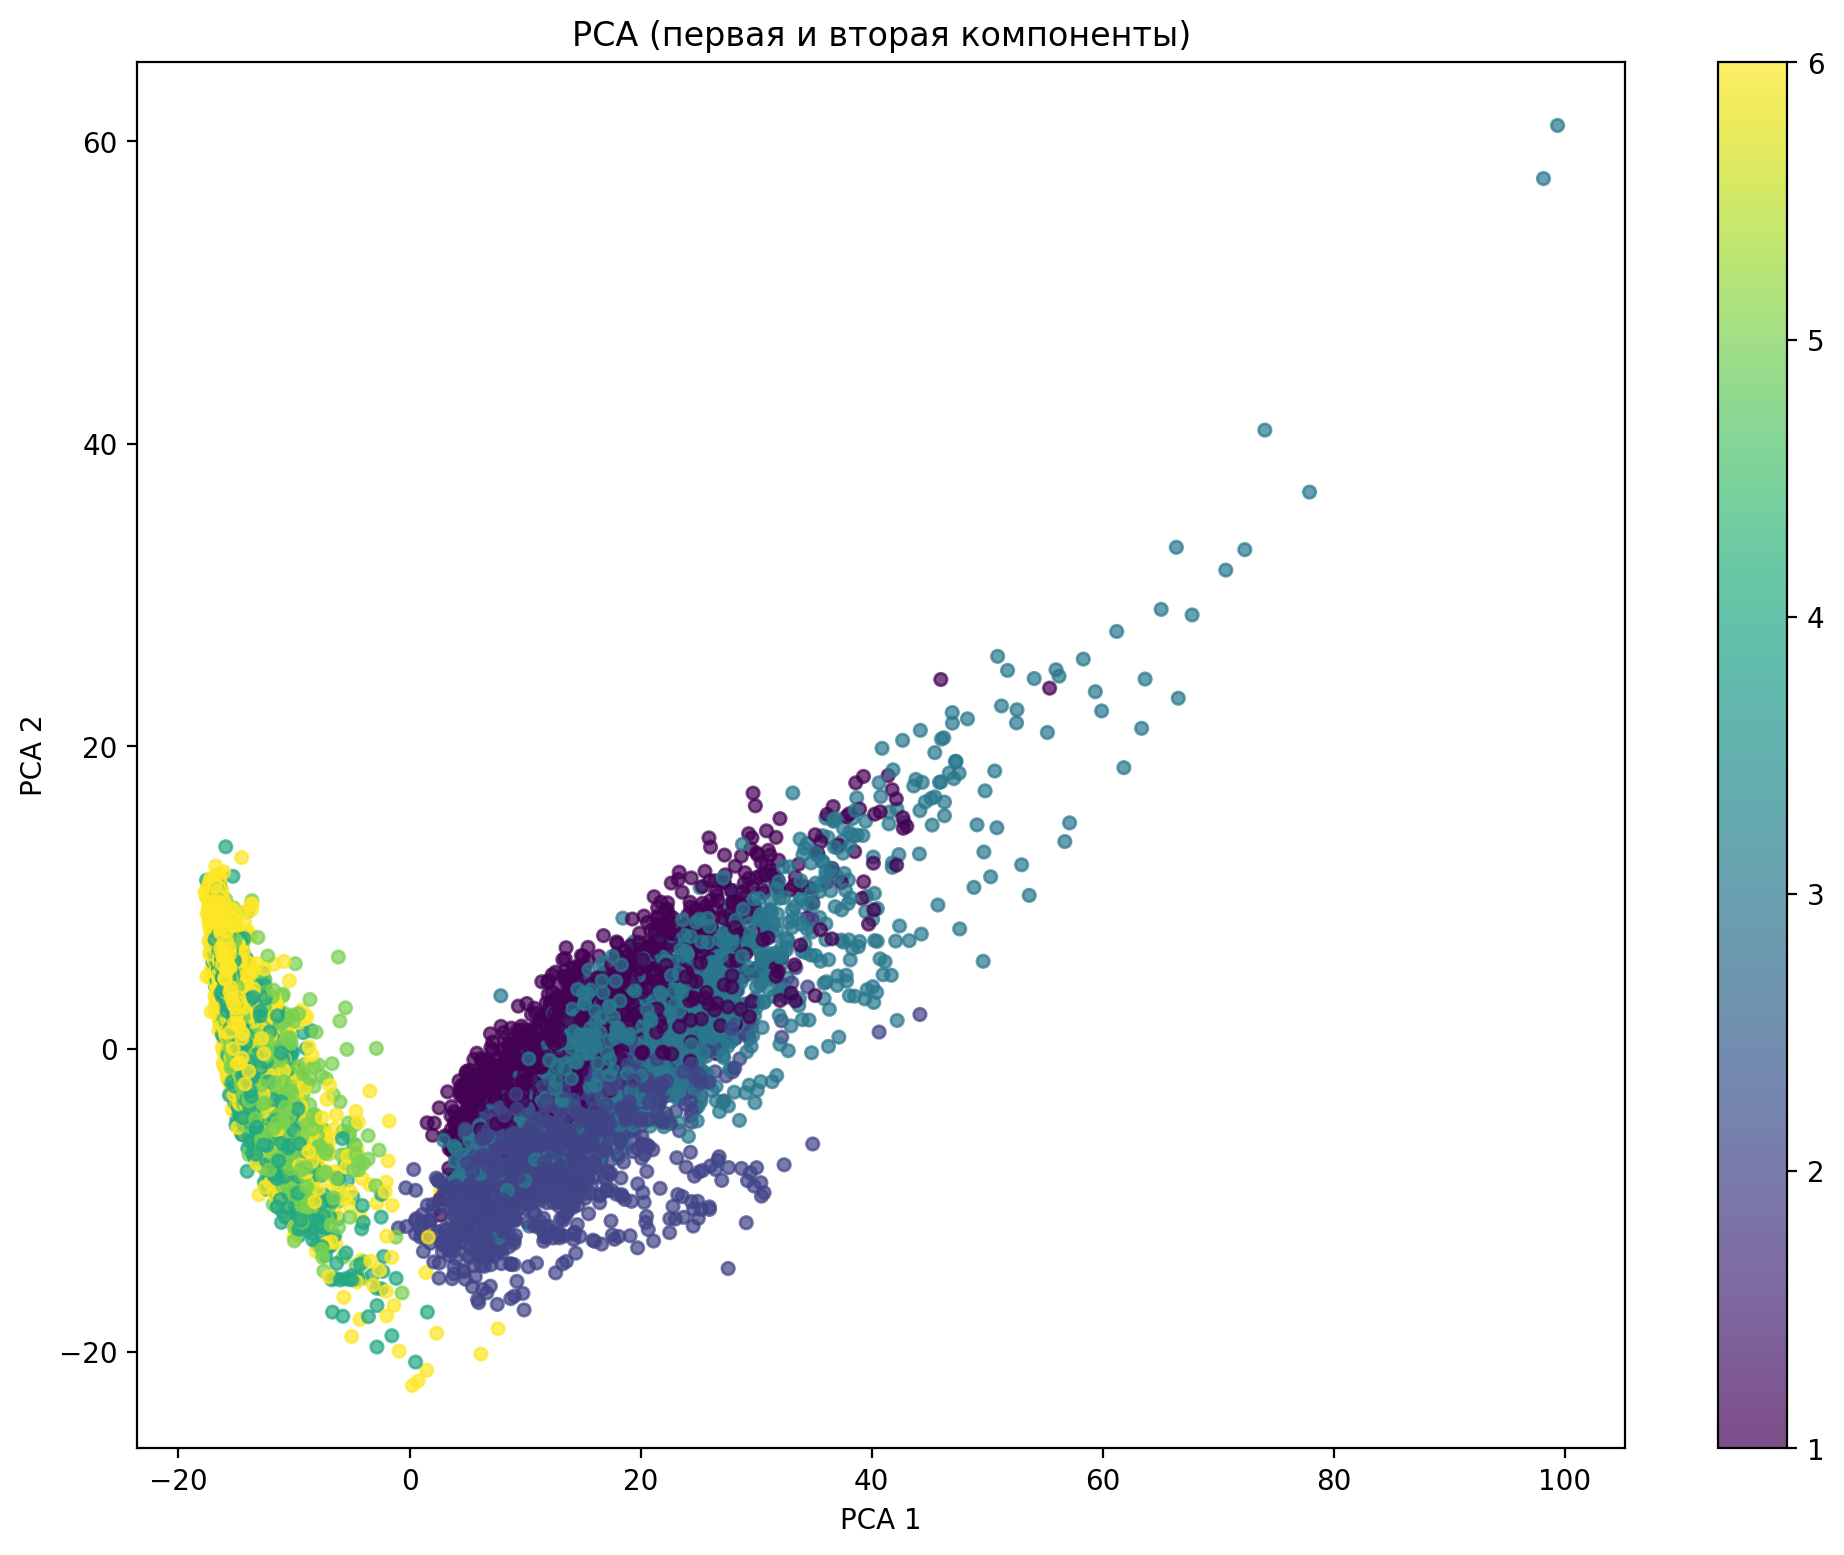

In [46]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=20, alpha=0.7)
plt.title('PCA (первая и вторая компоненты)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
%time kmeans.fit(X_pca)
%time labels_kmeans = kmeans.predict(X_pca)

CPU times: user 11 s, sys: 6.26 s, total: 17.3 s
Wall time: 13 s
CPU times: user 3.74 ms, sys: 3.09 ms, total: 6.83 ms
Wall time: 3.43 ms


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

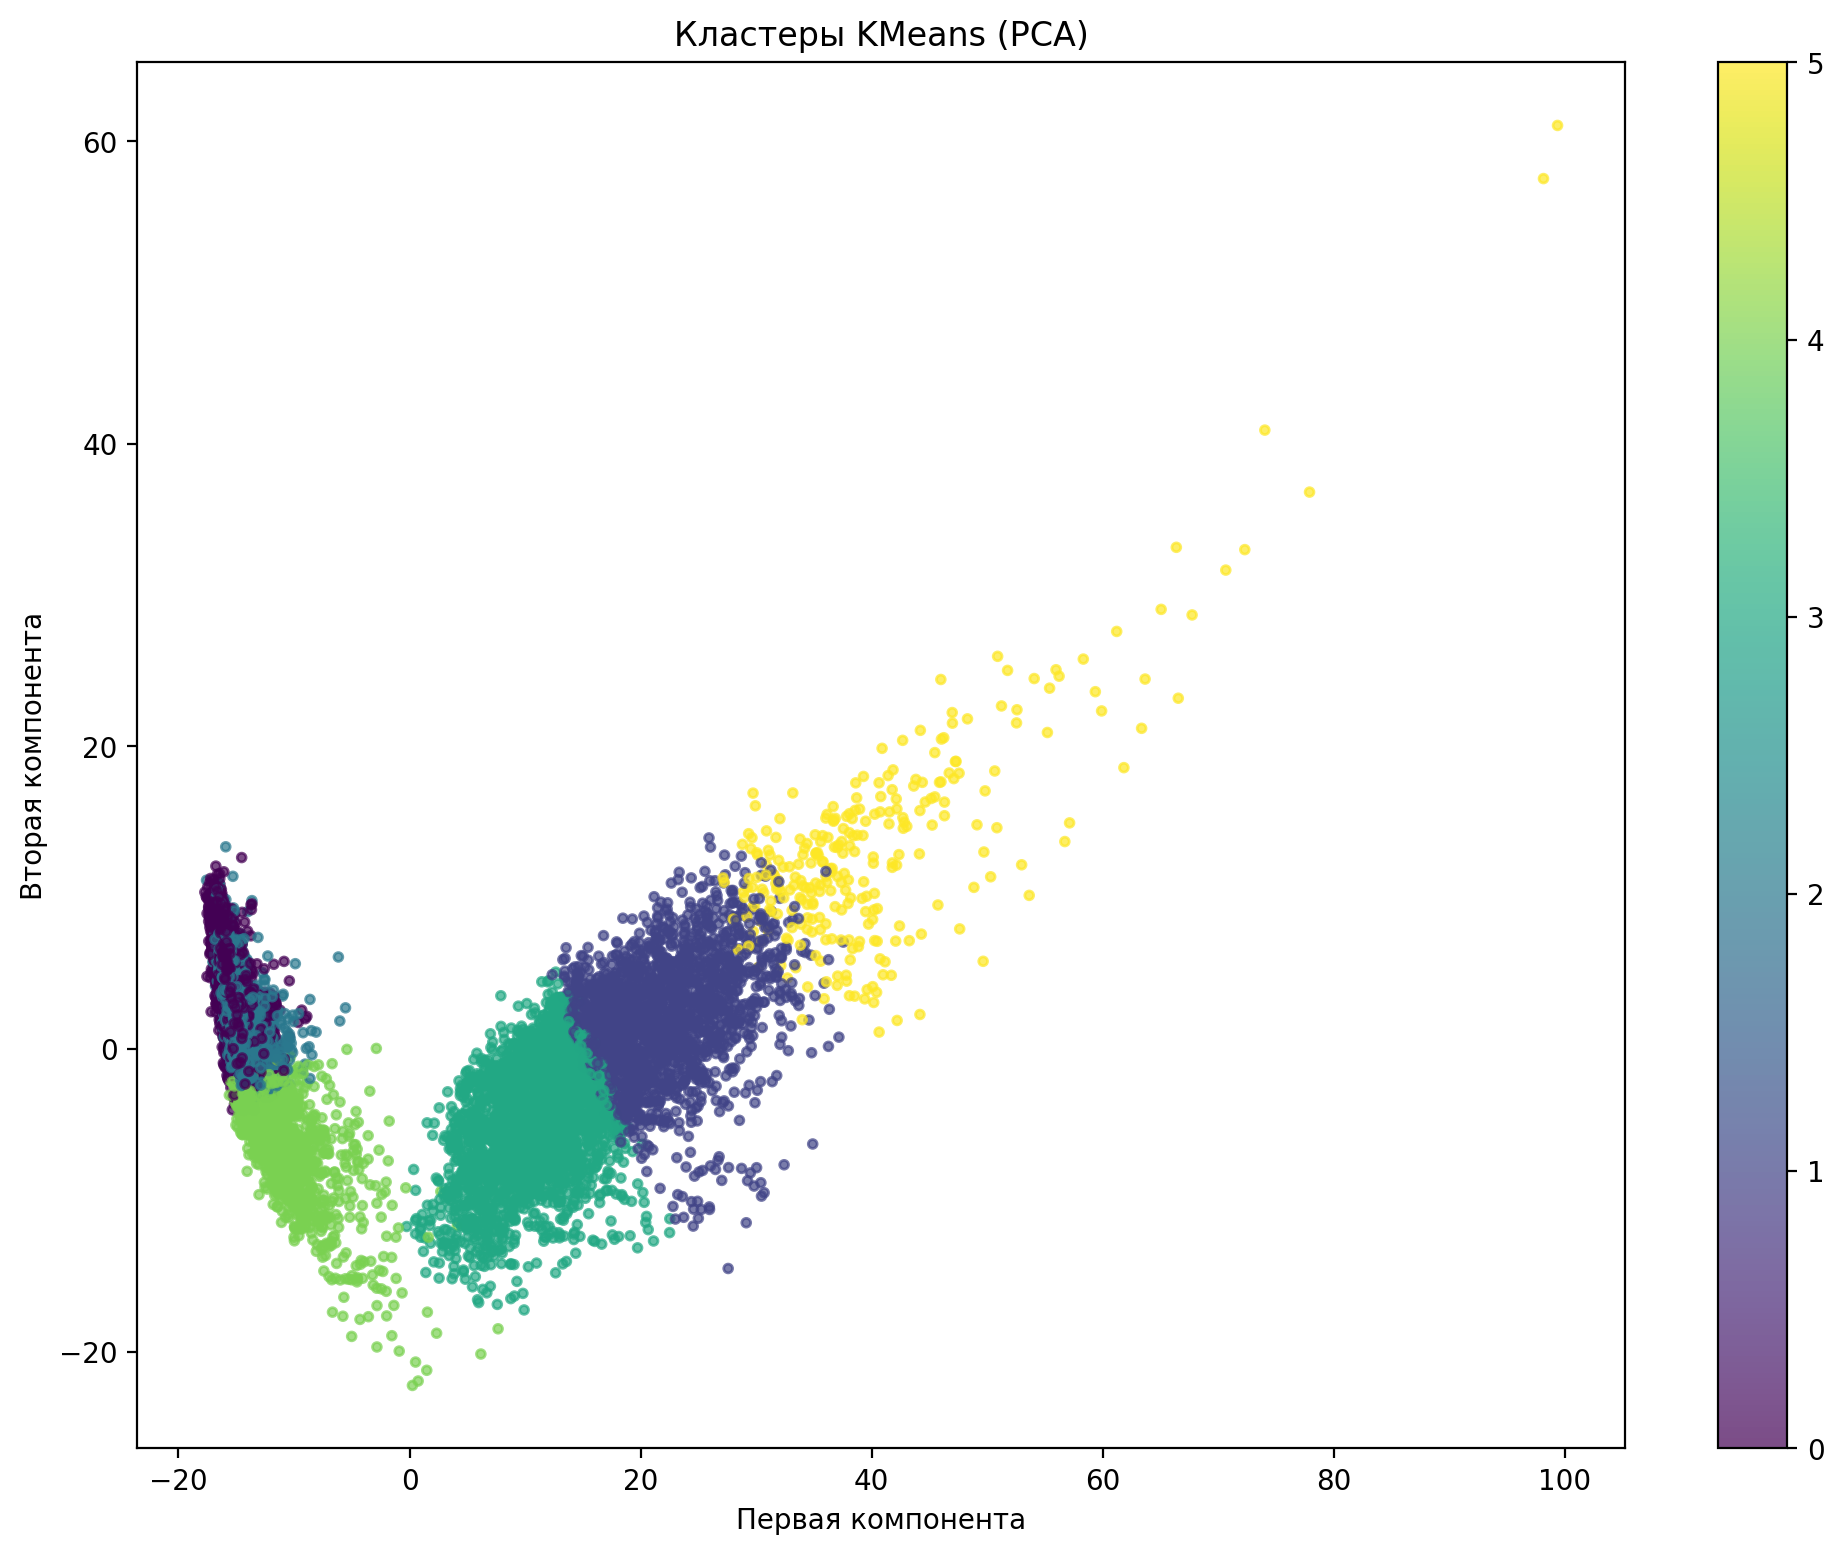

In [49]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=10, alpha=0.7)
plt.title('Кластеры KMeans (PCA)')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.colorbar()
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
ari_kmeans = adjusted_rand_score(y, kmeans.labels_)
silhouette_kmeans = silhouette_score(X_pca, kmeans.labels_)

print(f"ARI KMeans: {ari_kmeans:.3f}")
print(f"Silhouette Score KMeans: {silhouette_kmeans:.3f}")

ARI KMeans: 0.419
Silhouette Score KMeans: 0.141


ARI получился средним (0.419), что говорит о том, что KMeans лишь частично правильно нашел реальные группы активности. Silhouette Score (0.141) низкий, что указывает на нечеткие границы кластеров и низкую разделимость.

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

CPU times: user 9.68 s, sys: 699 ms, total: 10.4 s
Wall time: 16.1 s


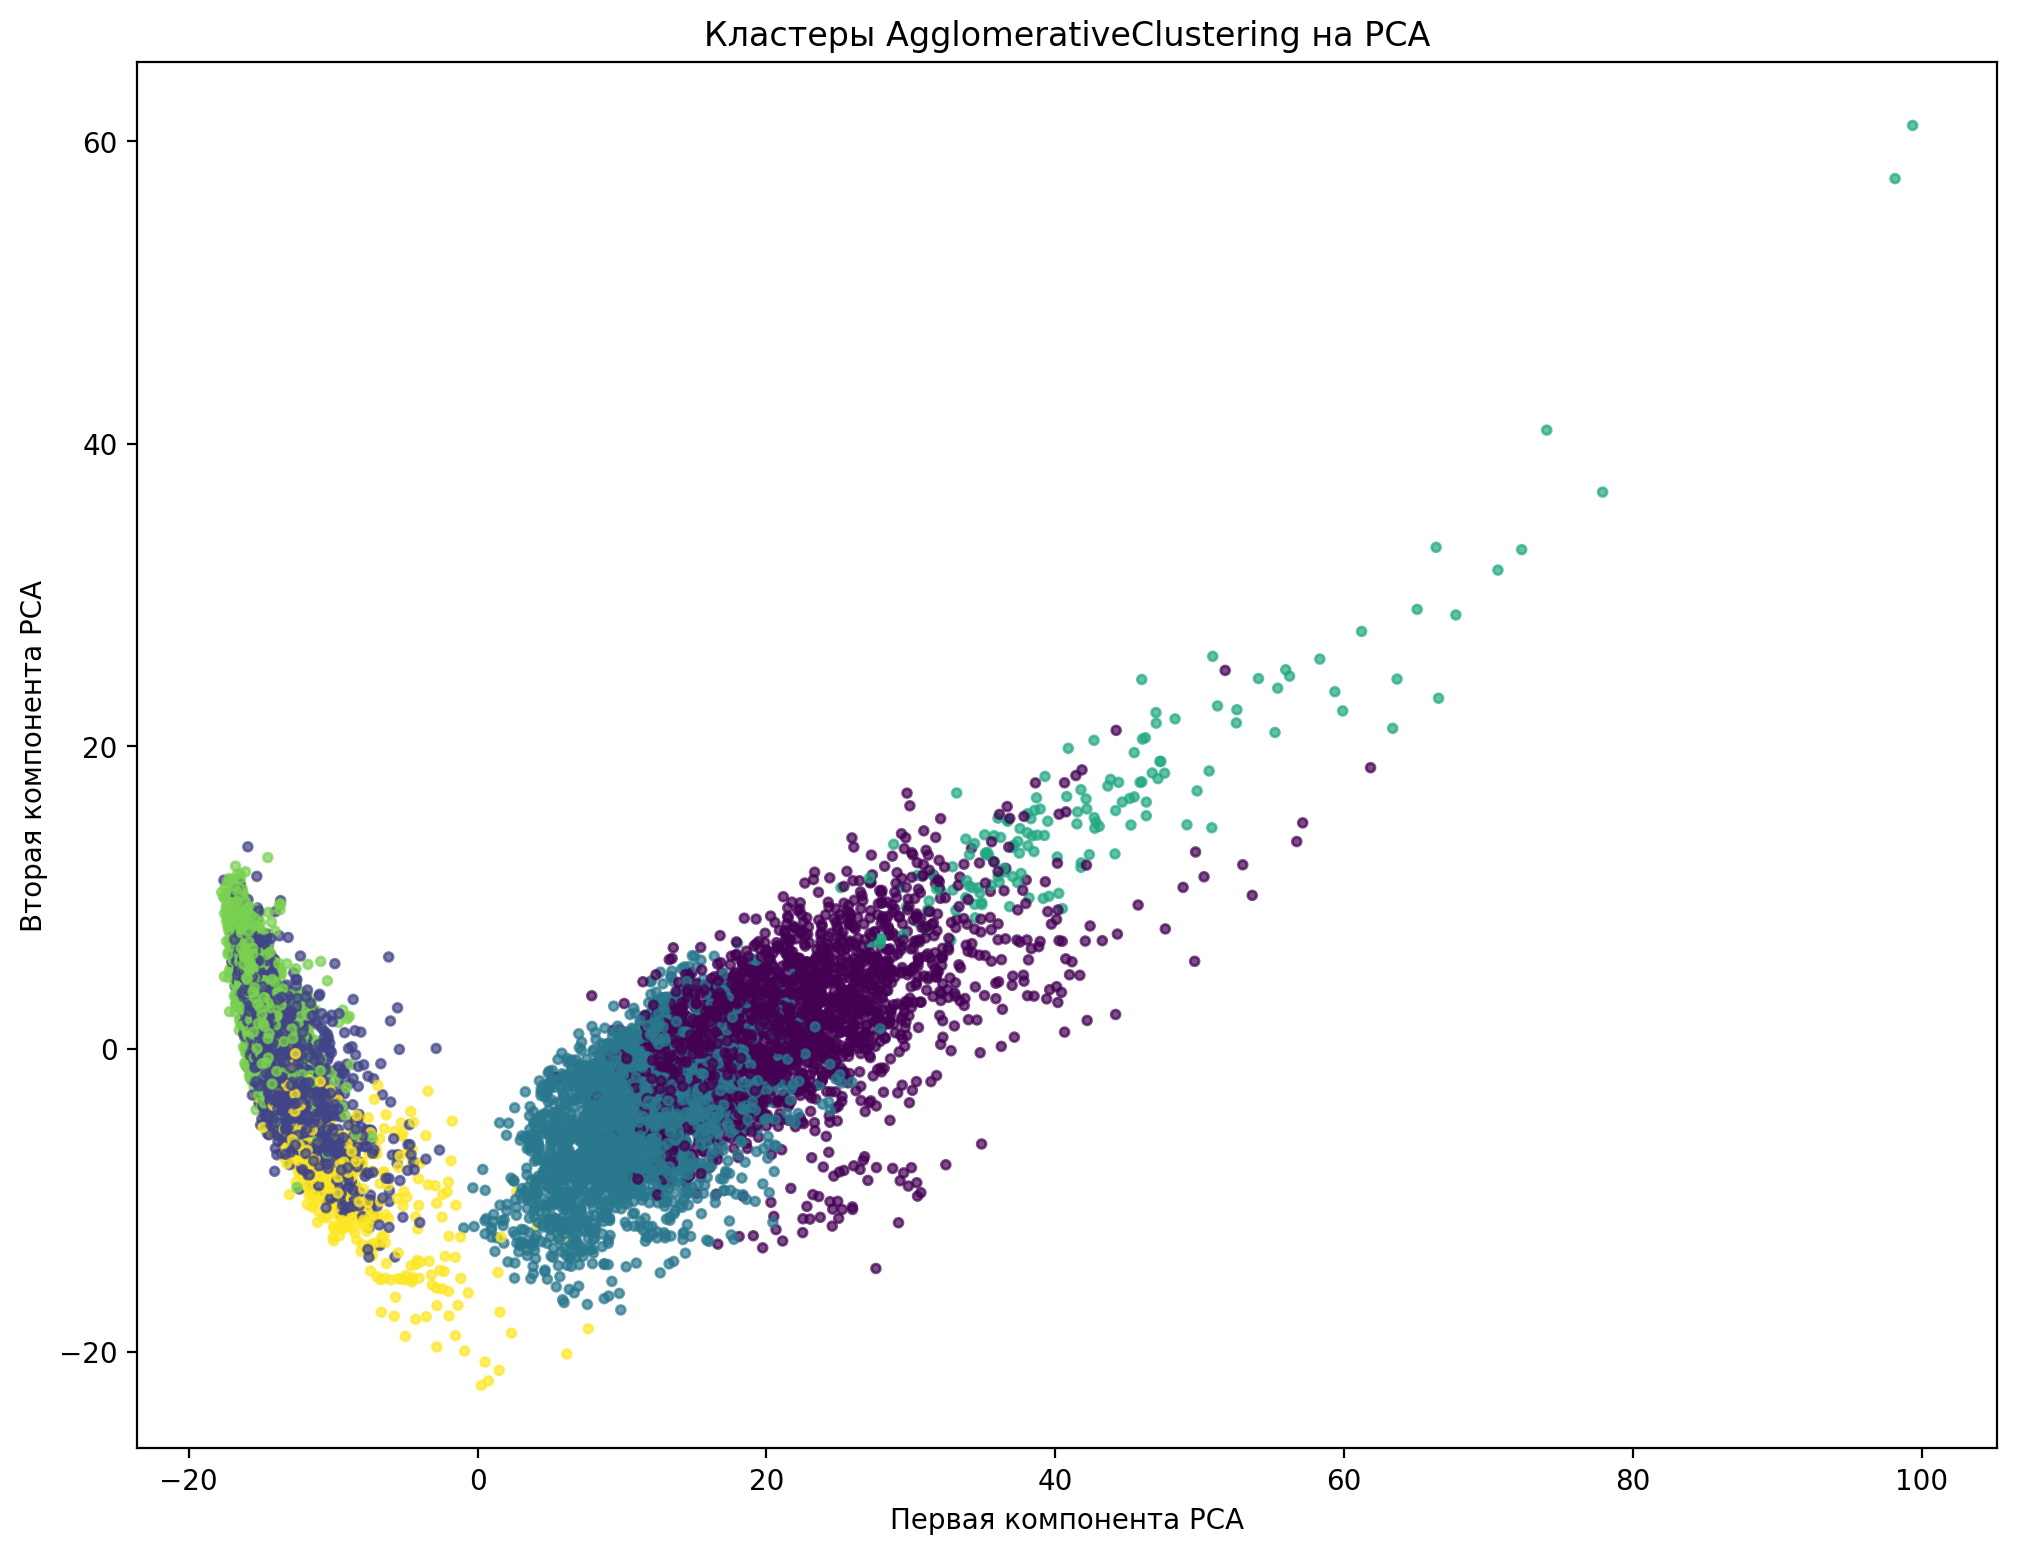

ARI Agglomerative: 0.494
Silhouette Score Agglomerative: 0.137
ARI KMeans: 0.419
Silhouette Score KMeans: 0.141


In [ ]:
agg = AgglomerativeClustering(n_clusters=6)

%time labels_agg = agg.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agg, cmap='viridis', s=10, alpha=0.7)
plt.title('Кластеры AgglomerativeClustering на PCA')
plt.xlabel('Первая компонента PCA')
plt.ylabel('Вторая компонента PCA')
plt.show()

ari_agg = adjusted_rand_score(y, labels_agg)
silhouette_agg = silhouette_score(X_pca, labels_agg)

print(f"ARI Agglomerative: {ari_agg:.3f}")
print(f"Silhouette Score Agglomerative: {silhouette_agg:.3f}")
print(f"ARI KMeans: {ari_kmeans:.3f}")
print(f"Silhouette Score KMeans: {silhouette_kmeans:.3f}")

**Ваш вывод здесь**

Agglomerative Clustering улучшил показатель ARI до 0.494, значит, лучше соответствует реальным типам активности. Однако, Silhouette Score у Agglomerative Clustering (0.137) немного хуже, чем у KMeans. Это говорит о том, что кластеры менее компактны

Agglomerative Clustering эффективнее обнаруживает естественную структуру активности

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

Да, похожи. представляют схожие типы активности, так как похожие данные группируются вместе.

в 1 и 5 класс смешиваются активности, в 3 и 5. Смешивается активность из-за схожести в характеристиках

Кластеризация получилась не очень качественной, так как метрики, такие как ARI и Silhouette Score, показывают слабую структуру кластеров.

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

На этом моменте у меня закончились ресурсы в колабе, поэтому делал локально

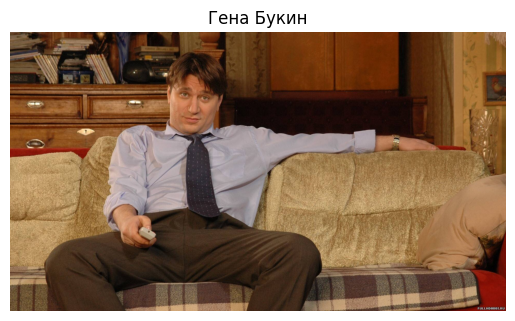

In [ ]:
img_url = r"C:\Users\alexu\OneDrive\Рабочий стол\ML5\gena.jpeg"
img = plt.imread(img_url)

plt.imshow(img)
plt.title('Гена Букин')
plt.axis('off')
plt.show()

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

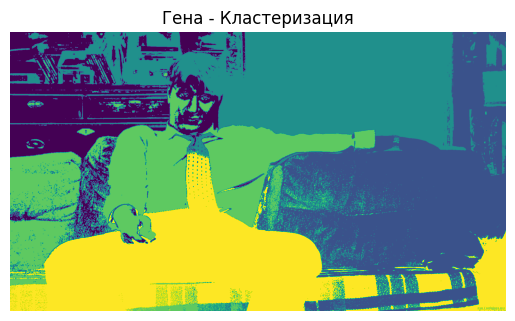

In [ ]:
def find_components(image_path, lmbd, n_clusters, title):
    image = np.array(Image.open(image_path))
    h, w, c = image.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h), indexing='xy')
    pixels = np.column_stack((lmbd * xx.ravel(), lmbd * yy.ravel(), image.reshape(-1, 3) / 255))

    scaler = StandardScaler()
    pixels_scaled = scaler.fit_transform(pixels)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels_scaled)

    plt.imshow(labels.reshape(h, w), cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

find_components(r"C:\Users\alexu\OneDrive\Рабочий стол\ML5\gena.jpeg", lmbd=0.5, n_clusters=5, title="Гена - Кластеризация")


КХАХААХАХХ, НУ КРАСИВЫЙ ЖЕ!!!

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

CPU times: total: 20min 49s
Wall time: 3min 3s


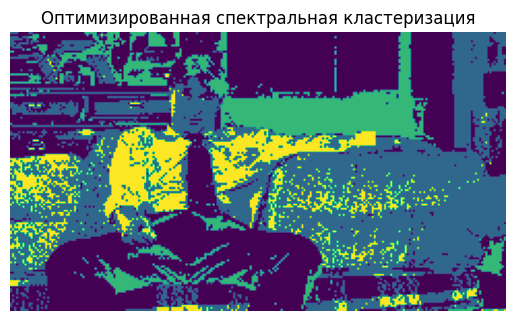

In [ ]:
img_path = r"C:\Users\alexu\OneDrive\Рабочий стол\ML5\gena.jpeg"
img = imread(img_path)

img_gray = rgb2gray(img)
img_gray_small = img_gray[::8, ::8]
img_flat = img_gray_small.reshape(-1, 1)
spectral = SpectralClustering(n_clusters=4, affinity='rbf', assign_labels='kmeans', random_state=42)

%time labels_spectral = spectral.fit_predict(img_flat)

plt.imshow(labels_spectral.reshape(img_gray_small.shape), cmap='viridis')
plt.title('Оптимизированная спектральная кластеризация')
plt.axis('off')
plt.show()

Я уменьшил Гену в 8 раз, если уменьшить 6 раз, то мой компьютер(r7 5800x, 32gb RAM) умирает, но он и так прекрасен 

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

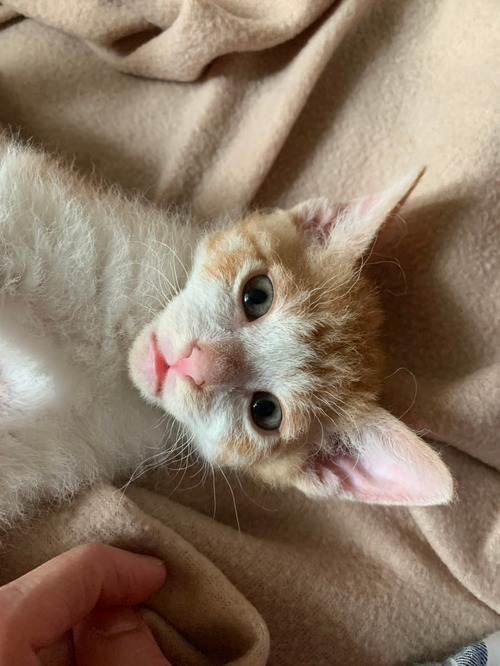